# FERNANDO LEON FRANCO | PRACTICA WORD2VEC SOBRE NUESTRO PROPOP TEXTO

In [1]:
import os
import re
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import polars as pl
from bs4 import BeautifulSoup
from colorstreak import Logger
from gensim.models import KeyedVectors, Word2Vec  # Version 4.3.3
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn import metrics, preprocessing, svm
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
from sklearn.manifold import TSNE

In [2]:
def pp(obj):
    print(pd.DataFrame(obj))

In [3]:
def print_bar(i, cantidad_registros, contexto="PROGRESO"):
    porcentaje = (i + 1) / cantidad_registros * 100
    # Con emojis
    barra = int(50 * (i + 1) / cantidad_registros) * "🟩"
    espacio = int(50 - len(barra)) * "⬛️"

    print(f"\r{contexto}: |{barra}{espacio}| {porcentaje:6.2f}%", end="", flush=True)

In [4]:

# ======================= Limpieza de texto =======================
def limpiar_texto(texto):
    
    texto = BeautifulSoup(texto, "html.parser").get_text()
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#+", "", texto)
    stop_words = set(stopwords.words("spanish"))
    texto_limpio = [word for word in texto.split() if word not in stop_words]
    return " ".join(texto_limpio)


# ======================= Carga de datos =======================
def get_texts_from_folder(path_folder):
    tr_txt = []  # aquí van los documentos
    tr_y = []  # aquí van las etiquetas

    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(path_folder, file))
            root = tree.getroot()
            docs = []
            for doc in root.iter("document"):
                texto_limpio = limpiar_texto(doc.text)
                docs.append(texto_limpio)
    
            tr_txt.append(" ".join(docs))

    truth_file = os.path.join(path_folder, "truth.txt")

    file_to_label = {}
    with open(truth_file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(":::")
            # País
            
            # pais = parts[2]
            # file_to_label[parts[0]] = pais
            
            # Genero
            genero = parts[1]
            file_to_label[parts[0]] = genero



    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            file_id = file.split(".")[0]
            if file_id in file_to_label:
                tr_y.append(file_to_label[file_id])

        print_bar(len(tr_y), len(file_to_label), contexto="CARGA DE ETIQUETAS")

    return tr_txt, tr_y


In [5]:
# ======================= Carga de datos =======================
path_test = '/Users/ferleon/Github/semestre_v/procesamiento_lenguaje/data/author_profiling/es_test'
path_train = '/Users/ferleon/Github/semestre_v/procesamiento_lenguaje/data/author_profiling/es_train'
tr_txt_train, tr_y_train = get_texts_from_folder(path_train)
#tr_txt_test, tr_y_test = get_texts_from_folder(path_test)

print(f"\nTextos train: {len(tr_txt_train)}, Etiquetas train: {len(tr_y_train)}")
#print(f"Textos test: {len(tr_txt_test)}, Etiquetas test: {len(tr_y_test)}")


paises = sorted(list(set(tr_y_train)))
paises_numericas = {pais: idx for idx, pais in enumerate(paises)}




y_train = [paises_numericas[pais] for pais in tr_y_train]
#y_test = [paises_numericas[pais] for pais in tr_y_test]

/var/folders/j4/21ypxx3x0019wgj7rqnlm2340000gn/T/ipykernel_49254/549244330.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  texto = BeautifulSoup(texto, "html.parser").get_text()


CARGA DE ETIQUETAS: |🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩| 100.02%
Textos train: 4200, Etiquetas train: 4200


In [6]:
TOP_PALABRAS = 1_000

corpus_de_palabras = []
for doc in tr_txt_train:
    corpus_de_palabras += word_tokenize(doc.lower())
    
lista_tweets_tokenizados = []
for doc in tr_txt_train:
    lista_tweets_tokenizados.append(word_tokenize(doc.lower()))

In [7]:
print(f"Tamaño del corpus de palabras: {len(corpus_de_palabras)}")
print(f"Primeros 10 tokens del corpus: {corpus_de_palabras[:10]}")

print(f"Número de documentos: {len(lista_tweets_tokenizados)}")
print(f"Primeros 10 tokens del primer documento: {lista_tweets_tokenizados[0][:10]}")

Tamaño del corpus de palabras: 3623899
Primeros 10 tokens del corpus: ['eln', 'asesina', 'policía', 'meten', 'bomba', 'cadáver', 'matar', 'inocentes.y', 'aún', 'cinismo']
Número de documentos: 4200
Primeros 10 tokens del primer documento: ['eln', 'asesina', 'policía', 'meten', 'bomba', 'cadáver', 'matar', 'inocentes.y', 'aún', 'cinismo']


In [8]:
distribucion_frecuencias = nltk.FreqDist(corpus_de_palabras)

vocabulario = [word for word, _ in distribucion_frecuencias.most_common(TOP_PALABRAS)]
print(f"Tamaño del vocabulario: {len(vocabulario)} | Primeras 10 palabras: {vocabulario[:10]}")
print(f"Tipo de vocabulario: {type(vocabulario)}")

dict_indices = {word: i for i, word in enumerate(vocabulario)}
print(f"Tipo de dict_indices: {type(dict_indices)}")
print(f"Diccionario de índices (primeras 10 entradas): {dict_indices}")

Tamaño del vocabulario: 1000 | Primeras 10 palabras: [',', '.', '!', '?', '...', ':', 'si', '``', "''", ')']
Tipo de vocabulario: <class 'list'>
Tipo de dict_indices: <class 'dict'>
Diccionario de índices (primeras 10 entradas): {',': 0, '.': 1, '!': 2, '?': 3, '...': 4, ':': 5, 'si': 6, '``': 7, "''": 8, ')': 9, '(': 10, 'q': 11, '-': 12, 'gracias': 13, 'vía': 14, 'hoy': 15, 'ser': 16, 'día': 17, 'mejor': 18, '..': 19, 'bien': 20, 'siempre': 21, 'así': 22, 'quiero': 23, 'vida': 24, 'ahora': 25, 'solo': 26, 'ver': 27, 'hace': 28, 'mas': 29, 'tan': 30, 'hacer': 31, 'año': 32, 'años': 33, 'no': 34, 'gente': 35, 'va': 36, 'puede': 37, 'd': 38, 'días': 39, 'vez': 40, 'feliz': 41, 'nunca': 42, 'voy': 43, 'bueno': 44, 'mal': 45, '@': 46, 'mundo': 47, 'creo': 48, '....': 49, 'video': 50, 'mañana': 51, 'jajaja': 52, 'amor': 53, 'cosas': 54, 'dios': 55, 'gran': 56, 'menos': 57, 'nuevo': 58, 'dos': 59, '3': 60, 'tiempo': 61, 'cada': 62, 'buen': 63, 'vamos': 64, '1': 65, ';': 66, 'alguien': 67, '

# EJECUTAR WORD2VEC  CON GENSIM

In [9]:
tamaño_vector = 50
ventana_contexto = 10
minimo_palabras = 1 # Este parámetro ignora todas las palabras con una frecuencia total menor a este valor
trabajadores = 8 # Procesadores a usar, si se pone más de 1, se usa multihilo



lista_de_tweets = lista_tweets_tokenizados


model = Word2Vec(lista_de_tweets, vector_size=tamaño_vector, window=ventana_contexto, min_count=minimo_palabras, workers=trabajadores)


In [10]:
# model.wv['ibero']
# Haciendo lo mismo pero con la funcion es:
model.wv.get_vector('pendejo')

array([ 0.58900195, -0.43343794, -1.0854349 ,  0.33442473, -1.029513  ,
       -0.62761253,  1.6369561 ,  1.4576966 , -1.7777488 ,  0.9788614 ,
        0.4052665 , -0.22630624, -0.00382452, -0.5305118 ,  0.21882471,
        0.5867957 ,  0.95646006, -0.27878812, -0.42107964, -1.9887682 ,
        1.0817821 , -0.17065671,  1.5603104 ,  0.34065482,  1.01687   ,
       -0.9050252 , -1.1526871 ,  0.60135293, -1.5151757 ,  0.43036935,
       -1.137167  ,  0.08631271,  1.251549  , -0.6345739 , -0.13225144,
        0.9872434 ,  1.3631413 , -0.0257923 ,  0.49533883, -0.81932384,
       -0.06992657,  0.76893336, -1.7822825 , -0.22236773,  2.5237978 ,
        0.1890061 , -0.36778158, -0.16733697, -0.16234066,  2.2978454 ],
      dtype=float32)

Text(0, 0.5, 'Valor')

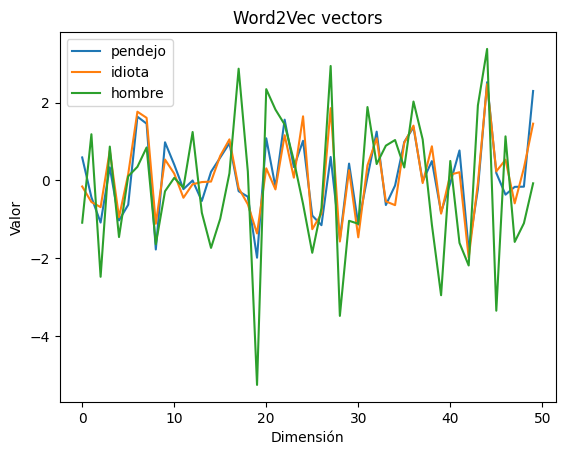

In [11]:
# Access vectors through model.wv (Word2Vec object is not subscriptable)
words = ['pendejo', 'idiota','hombre']
for w in words:
	if w in model.wv.key_to_index:
		vec = model.wv[w]
		plt.plot(vec, label=w)
	else:
		print(f"Palabra '{w}' no está en el vocabulario del modelo.")
plt.legend()
plt.title("Word2Vec vectors")
plt.xlabel("Dimensión")
plt.ylabel("Valor")

In [12]:
palabras_similares = model.wv.most_similar('pendejo')
pp(palabras_similares)

             0         1
0       hablen  0.915163
1        vaina  0.914366
2       idiota  0.907888
3        digan  0.905083
4      imbécil  0.903987
5     diciendo  0.898211
6  estupideces  0.895779
7         jode  0.895273
8      idiotas  0.891299
9       cagada  0.891105


In [13]:
palabras_similares = model.wv.most_similar('hdp')
pp(palabras_similares)

                  0         1
0              vago  0.952245
1              rata  0.950858
2            payaso  0.949017
3             metan  0.948252
4             guita  0.943901
5  juevesintratable  0.940375
6             ratas  0.938535
7           imbecil  0.938186
8             vagos  0.937070
9     espectaculosl  0.935166


In [14]:
palabras_similares = model.wv.most_similar('😂')
pp(palabras_similares)

                0         1
0               🙄  0.924073
1              😂😂  0.910983
2             😂😂😂  0.906492
3  jajajajajajaja  0.893234
4               😑  0.890958
5      jajajajaja  0.889043
6               🤔  0.884868
7               😏  0.883977
8    jajajajajaja  0.881208
9               😒  0.878307


In [15]:
pp( model.wv.most_similar(#negative=["hombre"], # Resta de un vector
                       positive=["hijo", "madre"], # Suma de dos vectores que se quieren agregar
                       ))

           0         1
0       hija  0.874725
1       puta  0.847809
2      parió  0.805690
3   chinguen  0.784747
4   pelotudo  0.760361
5      pario  0.759312
6       cara  0.757778
7  carnicero  0.757124
8      vieja  0.756169
9    maldito  0.753528


In [16]:
pp( model.wv.most_similar(negative=["hombre"], # Resta de un vector
                       positive=["futbol", "america"], # Suma de dos vectores que se quieren agregar
                       ))

              0         1
0       estadio  0.889559
1            vs  0.882476
2       vamosue  0.872647
3        ydaleu  0.870162
4          colo  0.868315
5    campeonato  0.864453
6    ponyfutbol  0.861162
7  libertadores  0.860080
8  sudamericana  0.857861
9        torneo  0.856211


In [17]:

def built_bow_tr_frecuencia(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=int)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = word_tokenize(tr.lower())
        fdist_doc = nltk.FreqDist(tokens)
        for word in fdist_doc:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = fdist_doc[word]
    return bow

In [18]:
bow_train_frecuencia = built_bow_tr_frecuencia(tr_txt_train,vocabulario,dict_indices)
print(bow_train_frecuencia)
bow_train_frecuencia.shape

[[44 22 52 ...  0  0  0]
 [ 9  4 76 ...  0  0  0]
 [ 5  5  4 ...  0  0  0]
 ...
 [41 44 21 ...  0  1  0]
 [30 34  9 ...  0  0  0]
 [60  4 67 ...  0  0  0]]


(4200, 1000)

In [19]:
# Aprende a como hacer selección de las palabras de manera muy interesante en automatico les da la relevancia
feature_selector = SelectKBest(chi2, k=TOP_PALABRAS)
feature_selector.fit(bow_train_frecuencia, y_train)
best = feature_selector.get_support(indices=True)

In [20]:
best

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [21]:
dict_indices_invertido = {valor: key for key, valor in dict_indices.items()}
dict_indices_invertido

{0: ',',
 1: '.',
 2: '!',
 3: '?',
 4: '...',
 5: ':',
 6: 'si',
 7: '``',
 8: "''",
 9: ')',
 10: '(',
 11: 'q',
 12: '-',
 13: 'gracias',
 14: 'vía',
 15: 'hoy',
 16: 'ser',
 17: 'día',
 18: 'mejor',
 19: '..',
 20: 'bien',
 21: 'siempre',
 22: 'así',
 23: 'quiero',
 24: 'vida',
 25: 'ahora',
 26: 'solo',
 27: 'ver',
 28: 'hace',
 29: 'mas',
 30: 'tan',
 31: 'hacer',
 32: 'año',
 33: 'años',
 34: 'no',
 35: 'gente',
 36: 'va',
 37: 'puede',
 38: 'd',
 39: 'días',
 40: 'vez',
 41: 'feliz',
 42: 'nunca',
 43: 'voy',
 44: 'bueno',
 45: 'mal',
 46: '@',
 47: 'mundo',
 48: 'creo',
 49: '....',
 50: 'video',
 51: 'mañana',
 52: 'jajaja',
 53: 'amor',
 54: 'cosas',
 55: 'dios',
 56: 'gran',
 57: 'menos',
 58: 'nuevo',
 59: 'dos',
 60: '3',
 61: 'tiempo',
 62: 'cada',
 63: 'buen',
 64: 'vamos',
 65: '1',
 66: ';',
 67: 'alguien',
 68: '2',
 69: 'trump',
 70: 'casa',
 71: 'via',
 72: 'mismo',
 73: 'país',
 74: 'puedo',
 75: 'x',
 76: 'tener',
 77: 'verdad',
 78: "'",
 79: '“',
 80: 'buena',


In [22]:
t_words = [dict_indices_invertido[index] for index in best]
# dict_indices {"palabra": "dimension_en_bow",...}
matris_objetivo = np.array([model.wv[dict_indices[word]] for word in t_words])

reduce_matrix = TSNE(n_components=2).fit_transform(matris_objetivo)

max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


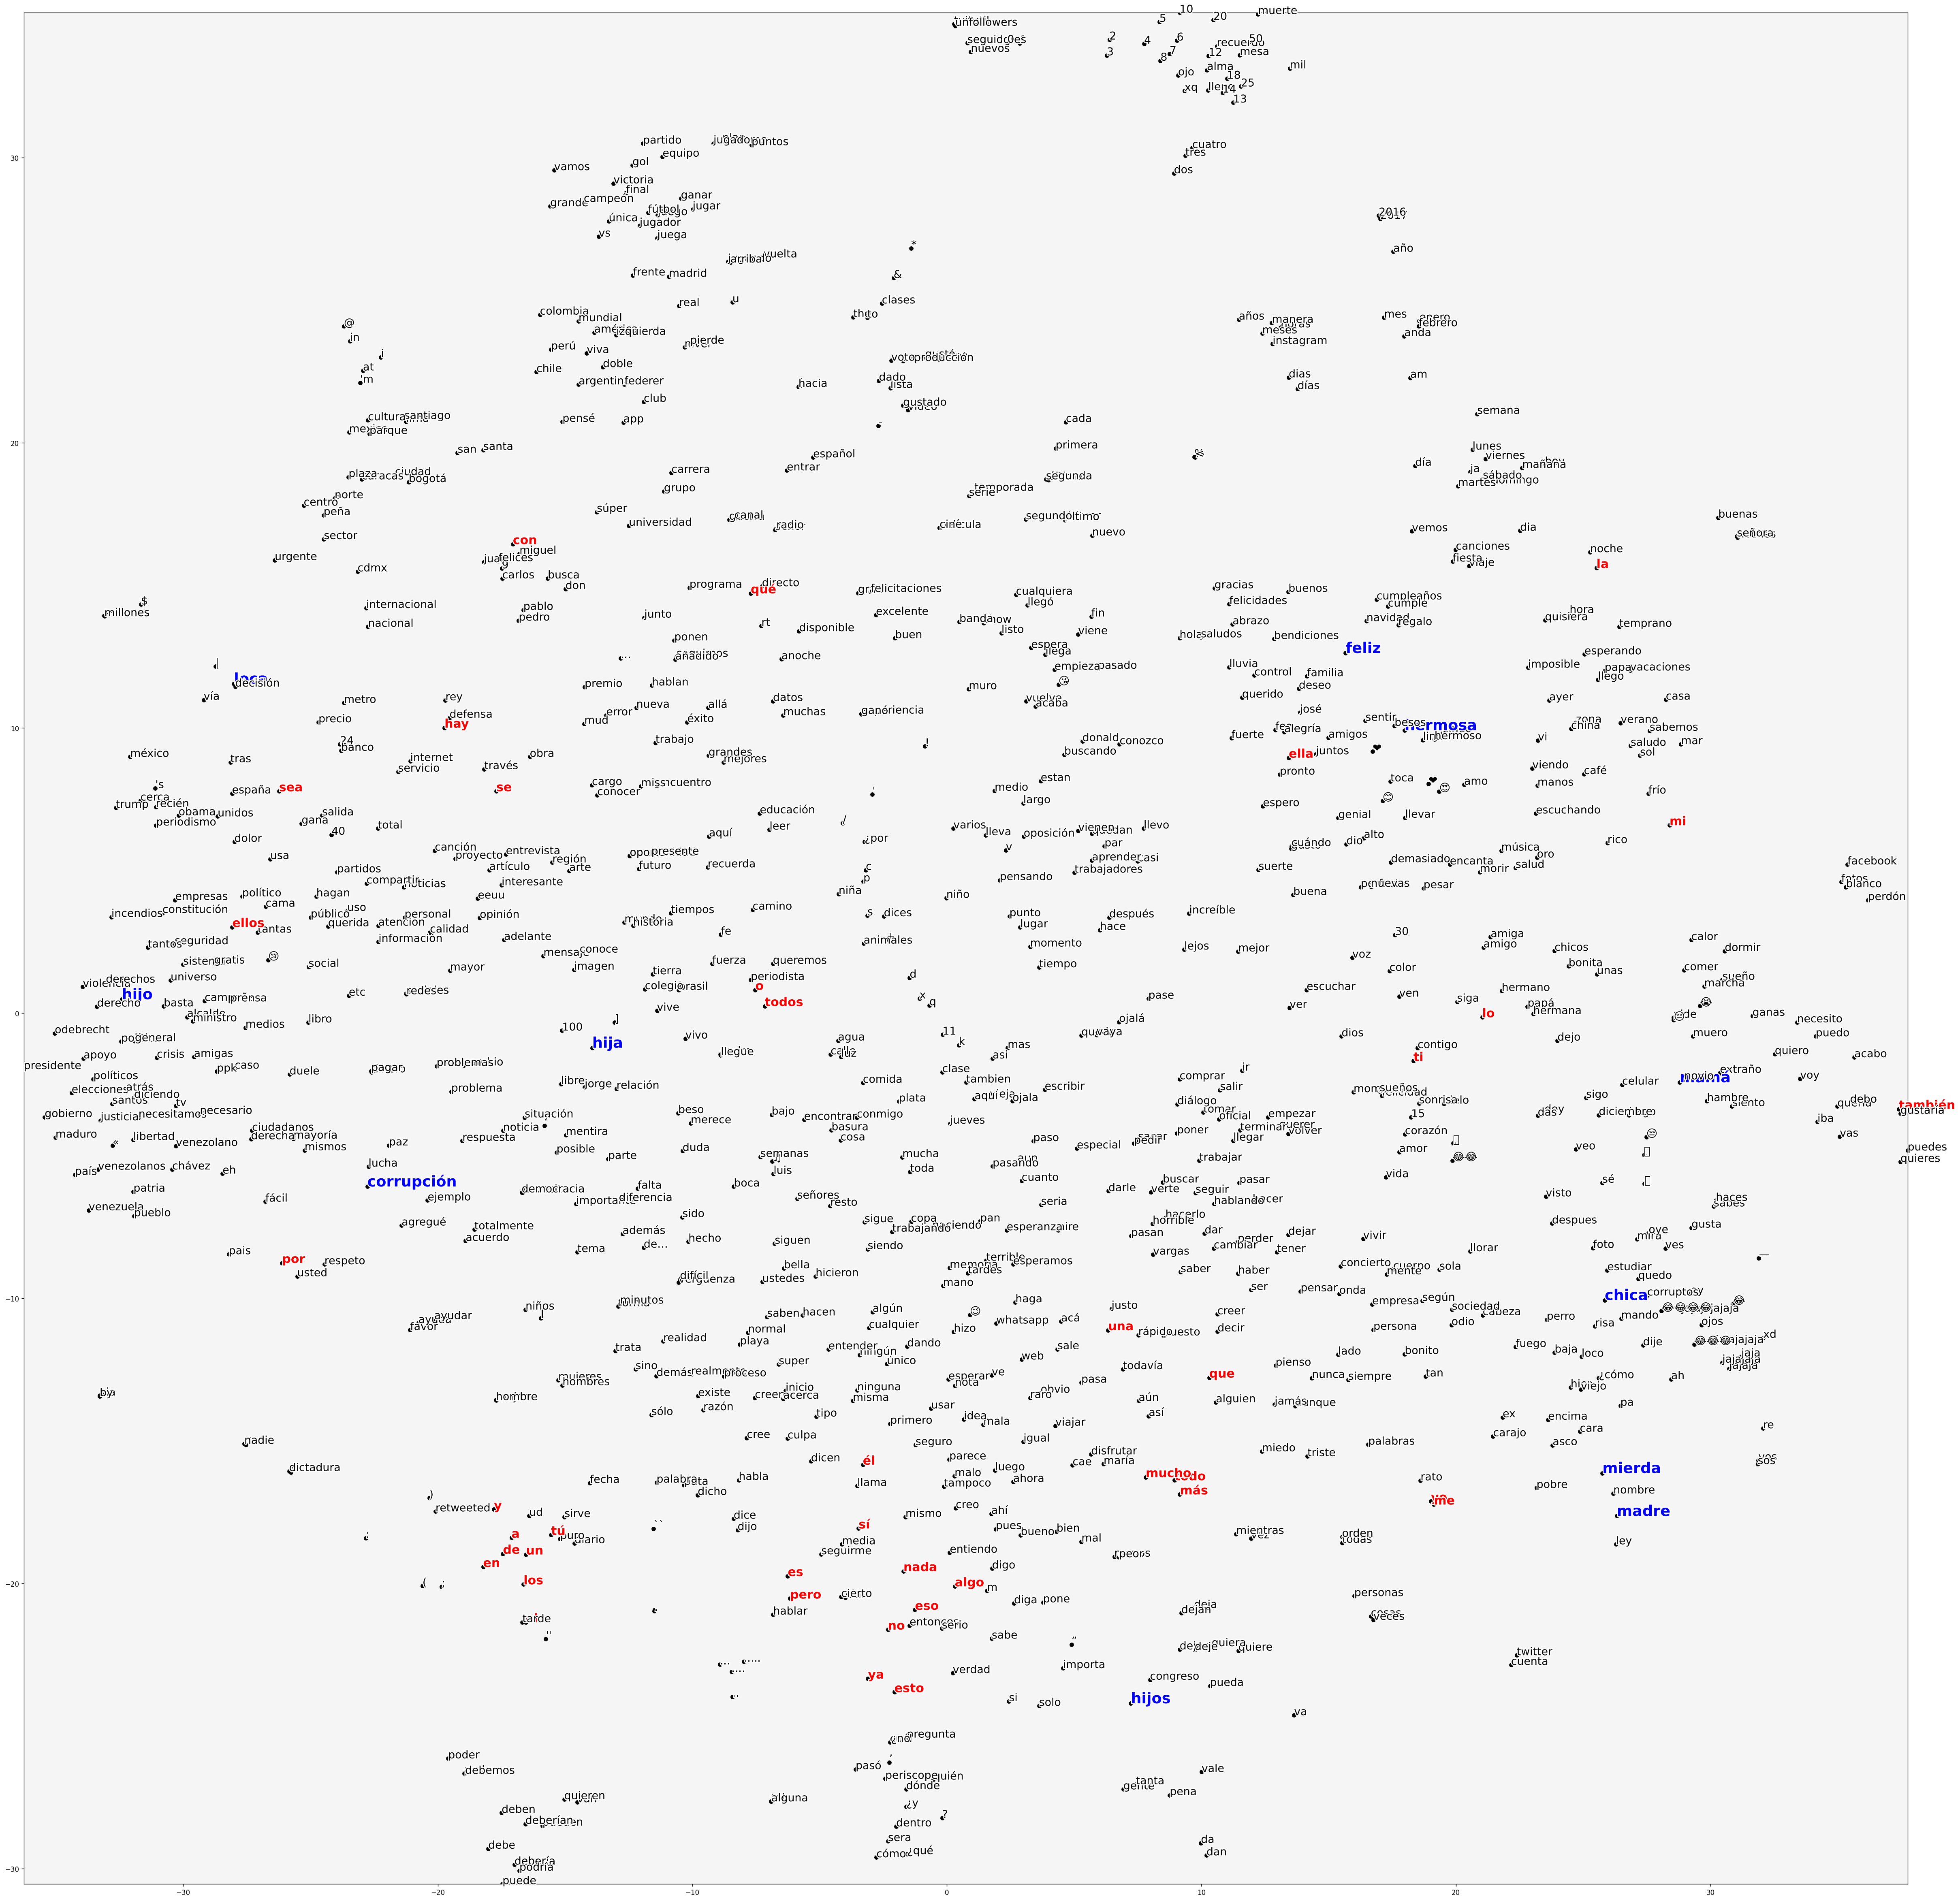

In [23]:
from matplotlib import patheffects

x, y = reduce_matrix[:, 0], reduce_matrix[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')






stop_words = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in stop_words:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()
